## Inference

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from Autoencoder import Autoencoder
import yaml
import os
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and set to eval mode
model = Autoencoder()

# Load model.pth if exists
try:
	model.load_state_dict(torch.load("models/Autoencoder_norm.pth"))
except FileNotFoundError:
	print("No model.pth found")
model.to(device)
model.eval()

# Define a transform to preprocess the image
transform = transforms.Compose([
		transforms.Resize((256,256)),
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	])

# Load data path
with open("../config.yml", "r") as file:
	config = yaml.safe_load(file)
	data_path = config["dataset_path"]

Using cuda device


In [2]:
# Load and preprocess the image
# image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-25_0/02816.png")) # Negative
image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-37_0/00045_Aug1.png")).convert("RGB") # Positive
input_image = transform(image).unsqueeze(0) # Add batch dimension
print(input_image.shape)

torch.Size([1, 3, 256, 256])


In [8]:
# Perform a forward pass to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image.to(device))

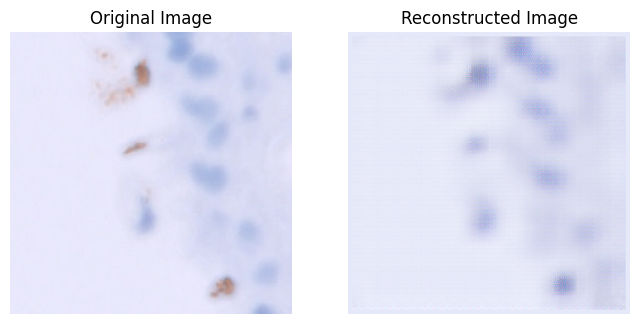

In [28]:
def denormalize(tensor):
	tensor = tensor * 0.5 + 0.5
	tensor = tensor * 255
	tensor = tensor.clamp(0, 255)
	tensor = tensor.type(torch.uint8)
	return tensor

# Convert tensors to images for visualization
input_image_np = denormalize(input_image.squeeze(0).cpu()).permute(1, 2, 0).numpy()
reconstructed_image_np = denormalize(reconstructed_image.squeeze(0).cpu()).permute(1, 2, 0).numpy()
# center cropped
p = 4
reconstructed_image_np = reconstructed_image_np[p:256-p, p:256-p, :]
# pad again with blue color
reconstructed_image_np = cv2.copyMakeBorder(reconstructed_image_np, p, p, p, p, cv2.BORDER_CONSTANT, value=[228, 232, 248])

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis("off")

plt.show()

In [49]:
def check_red_fraction(orig, reco):
	# Convert the images from RGB to HSV
	input_image_hsv = cv2.cvtColor(orig, cv2.COLOR_RGB2HSV)
	reconstructed_image_hsv = cv2.cvtColor(reco, cv2.COLOR_RGB2HSV)

	# Define the hue range for red pixels as suggested
	# For -20 to 0 in HSV, which corresponds to hues 160-180 in OpenCV's scale
	input_lower_hsv1 = np.array([340, 0, 0])
	input_upper_hsv1 = np.array([360, 255, 255])

	# For 0 to 20 in HSV
	input_lower_hsv2 = np.array([0, 0, 0])
	input_upper_hsv2 = np.array([20, 255, 255])

	# Apply masks to the original image
	mask_ori1 = cv2.inRange(input_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_ori2 = cv2.inRange(input_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_ori = cv2.bitwise_or(mask_ori1, mask_ori2)
	count_red_ori = np.count_nonzero(mask_ori)

	# Apply masks to the reconstructed image
	mask_rec1 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_rec2 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_rec = cv2.bitwise_or(mask_rec1, mask_rec2)
	count_red_rec = np.count_nonzero(mask_rec)

	# Calculate the fraction of red pixels
	F_red = count_red_ori / (count_red_rec+1)

	return F_red

check_red_fraction(input_image_np, reconstructed_image_np)

305.0

In [38]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader

dataset = HelicoDatasetClassification()
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [39]:
next(iter(dataloader))[0].shape, next(iter(dataloader))[1]

(torch.Size([16, 3, 256, 256]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

In [50]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = HelicoDatasetClassification()
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

red_fracs = []
labels = []
for batch in tqdm(dataloader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		red_fracs.append(check_red_fraction(
			b_orig_images[i].permute(1, 2, 0).cpu().numpy(),
			reco_images[i].permute(1, 2, 0).cpu().numpy()
		))
	labels.extend(b_labels.cpu().numpy())
labels = np.array(labels)

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


In [51]:
print(red_fracs[:15])

[0.007407407407407408, 0.5583333333333333, 0.056, 0.15555555555555556, 0.0, 0.006993006993006993, 0.0, 0.0, 0.18627450980392157, 0.0, 0.009708737864077669, 1.9514563106796117, 0.13636363636363635, 0.0, 0.35294117647058826]


In [52]:
print(labels[:15])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


AUC: 0.958
Optimal red fraction threshold: 0.6494845360824743


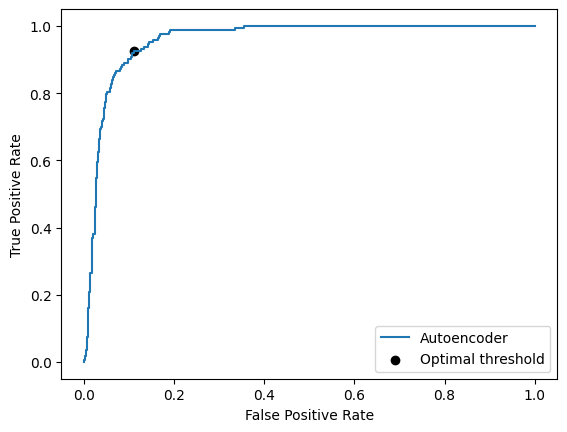

In [53]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# sort red_fracs and labels by red_fracs
red_fracs = np.array(red_fracs)
labels = np.array(labels)
inds = red_fracs.argsort()
sorted_red_fracs = red_fracs[inds]
sorted_labels = labels[inds]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_red_fracs)
# calculate AUC
auc = roc_auc_score(sorted_labels, sorted_red_fracs)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_red_frac = thresholds[optimal_idx]
print(f"Optimal red fraction threshold: {optimal_red_frac}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Accuracy: 0.893
Precision: 0.564
Recall: 0.920
F1: 0.699


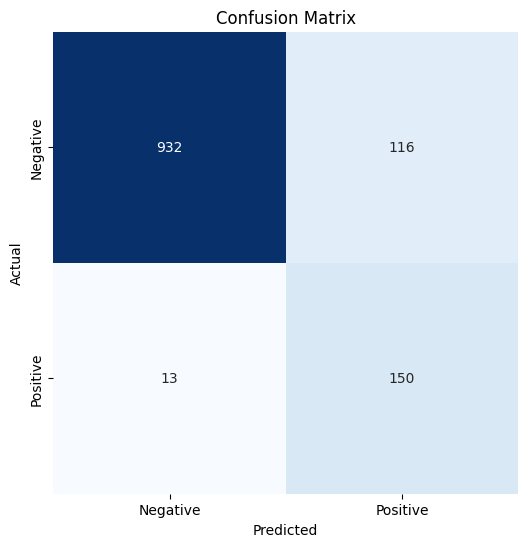

In [54]:
import seaborn as sns

# confusion matrix
y_pred = red_fracs > optimal_red_frac
cm = confusion_matrix(labels, y_pred)

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()